# Task 1: Simple model ensembling

You are given a pipeline that trains a convolutional neural network to classify images of horses and deers from the CIFAR10 dataset. The images are 32 x 32 pixels and have 3 color channels. The example pipeline is set to train for 2 epochs in under 30 seconds, achieving > 80% accuracy on the test set. The code for this task is provided, and it is recommended that you use a GPU on Colab to ensure faster training times (but even without GPU, single model should train in around 30 seconds).

Your task is to develop an ensemble of 7 networks, trained with the same architecture and data, but initialized differently and seeing different order of batches. The ensembling output should be the mean of the network outputs (logits).

(Note that models will by default be initialized differently and they will by default see different order of batches; no need to do anything special.)

To accomplish this, you should:
1. Fill in the missing parts of the test_multiple function.
2. Train 7 models and test ensemblings of different sizes (1 through 7).
3. Plot the test accuracy and cross-entropy loss depending on the number of models in the ensemble.


Some helpful hints:
* You can test ensembles of different sizes by passing a subset of the models to the test function (e.g., models[:3] or models[:ensemble_size]). You don't need to train separate ensembles for each size.
* Be sure to take the mean of the model outputs (logits) to compute cross-entropy correctly.
* Generally, using 2-3 models will give noticeable improvement over using just one model, and adding each additional model to the ensemble gives diminishing returns.
* It's normal for a larger ensemble to be, sometimes, slightly worse than a smaller one due to chance.
* You may find it helpful to reference earlier code provided in the task.

# Single model training (DO NOT CHANGE THIS SECTION)

In [1]:
import random
import typing
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

In [2]:
batch_size = 500
test_batch_size = 1000
epochs = 2
lr = 1e-2
use_cuda = True
seed = 1
log_interval = 10
num_models = 7

In [3]:
def extract_classes(dataset_: torch.utils.data.Dataset, class_1: str, class_2: str) -> torch.utils.data.Dataset:
    c1_index = dataset_.classes.index(class_1)
    c2_index = dataset_.classes.index(class_2)
    mask = np.logical_or(np.equal(dataset_.targets, c1_index), np.equal(dataset_.targets, c2_index))
    dataset_.data = dataset_.data[mask, :]
    dataset_.targets = np.array(dataset_.targets)[mask]
    dataset_.targets[dataset_.targets == c1_index] = 0
    dataset_.targets[dataset_.targets == c2_index] = 1
    dataset_.targets = list(dataset_.targets)
    assert np.all(np.logical_or(np.equal(dataset_.targets, 0), np.equal(dataset_.targets, 1)))
    return dataset_

In [4]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), 
                             (0.2023, 0.1994, 0.2010))
    ])

train_dataset = CIFAR10(root="~", download=True, train=True, transform=transform)
test_dataset = CIFAR10(root="~", download=True, train=False, transform=transform)
train_dataset = extract_classes(train_dataset, "horse", "deer")
test_dataset = extract_classes(test_dataset, "horse", "deer")

In [5]:
use_cuda = not use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset,**train_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, (3,3), 1, 1)
        self.batchnorm1 = nn.BatchNorm2d(num_features=10)
        self.conv2 = nn.Conv2d(10, 20, (3,3), 1, 1)
        self.batchnorm2 = nn.BatchNorm2d(num_features=20)
        self.fc1 = nn.Linear(8*8*20, 128)
        self.batchnorm3 = nn.BatchNorm1d(num_features=128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.batchnorm3(x)
        x = F.relu(x)
        output = self.fc2(x)
        return output

In [8]:
def train(model: nn.Module, device: torch.device, train_loader: torch.utils.data.DataLoader, optimizer: torch.optim.Adam, epoch: int, log_interval: int) -> None:
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader) -> typing.List[float]:
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # cross_entropy expects logits, so output contains logits, not probabilities
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    accuracy =  correct / len(test_loader.dataset)
    return accuracy, test_loss

In [9]:
model = Net()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
accuracies = []
test_losses = []

# accuracy and test loss before training
accuracy, test_loss = test(model, device, test_loader)
accuracies.append(accuracy)
test_losses.append(test_loss)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    accuracy, test_loss = test(model, device, test_loader)
    accuracies.append(accuracy)
    test_losses.append(test_loss)


Test set: Average loss: 0.6957, Accuracy: 1003/2000 (50%)

Train Epoch: 1 [0/10000 (0%)]	Loss: 0.719690
Train Epoch: 1 [5000/10000 (50%)]	Loss: 0.500683

Test set: Average loss: 0.4585, Accuracy: 1571/2000 (79%)

Train Epoch: 2 [0/10000 (0%)]	Loss: 0.442570
Train Epoch: 2 [5000/10000 (50%)]	Loss: 0.389463

Test set: Average loss: 0.3811, Accuracy: 1653/2000 (83%)



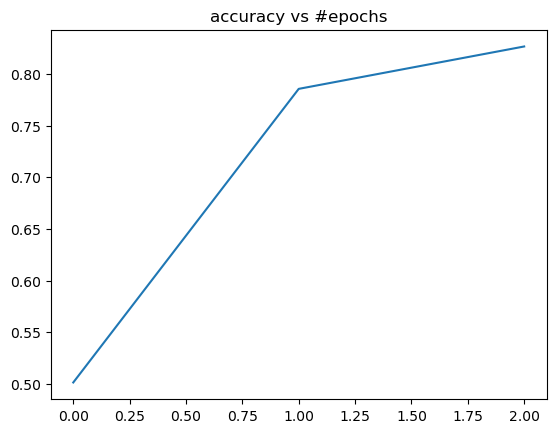

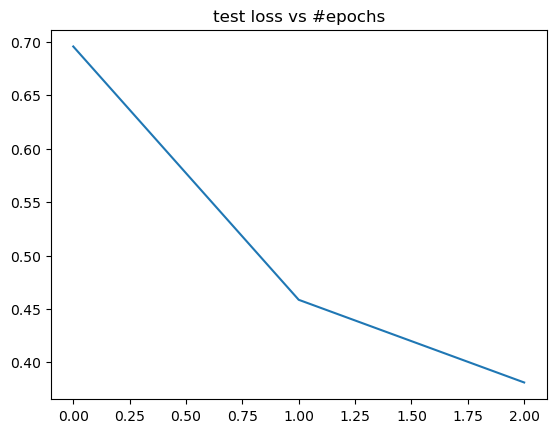

In [10]:
# Plotting accuracy and test loss with x-axis being number of epochs.
plt.plot(accuracies)
plt.title('accuracy vs #epochs')
plt.show()
plt.plot(test_losses)
plt.title('test loss vs #epochs')
plt.show()

# Training and Testing a Model Ensemble

In [11]:
# Training ensembles (given)
models = [Net() for i in range(num_models)]
optimizers = [optim.Adam(models[i].parameters(), lr=lr) for i in range(num_models)]

for i, (model, optimizer) in enumerate(zip(models, optimizers)):
  ################################
  # TODO: train each model for 2 epochs.
  # No evaluation/testing needed between epochs.
  ################################
  
  model.to(device)
  accuracies = []
  test_losses = []

  train(model, device, train_loader, optimizer, 1, log_interval)
  train(model, device, train_loader, optimizer, 2, log_interval)


Train Epoch: 1 [0/10000 (0%)]	Loss: 0.696326
Train Epoch: 1 [5000/10000 (50%)]	Loss: 0.516157
Train Epoch: 2 [0/10000 (0%)]	Loss: 0.431463
Train Epoch: 2 [5000/10000 (50%)]	Loss: 0.414025
Train Epoch: 1 [0/10000 (0%)]	Loss: 0.724589
Train Epoch: 1 [5000/10000 (50%)]	Loss: 0.517138
Train Epoch: 2 [0/10000 (0%)]	Loss: 0.410691
Train Epoch: 2 [5000/10000 (50%)]	Loss: 0.404902
Train Epoch: 1 [0/10000 (0%)]	Loss: 0.816187
Train Epoch: 1 [5000/10000 (50%)]	Loss: 0.513155
Train Epoch: 2 [0/10000 (0%)]	Loss: 0.424990
Train Epoch: 2 [5000/10000 (50%)]	Loss: 0.399516
Train Epoch: 1 [0/10000 (0%)]	Loss: 0.777820
Train Epoch: 1 [5000/10000 (50%)]	Loss: 0.566745
Train Epoch: 2 [0/10000 (0%)]	Loss: 0.466391
Train Epoch: 2 [5000/10000 (50%)]	Loss: 0.425259
Train Epoch: 1 [0/10000 (0%)]	Loss: 0.754897
Train Epoch: 1 [5000/10000 (50%)]	Loss: 0.511584
Train Epoch: 2 [0/10000 (0%)]	Loss: 0.410812
Train Epoch: 2 [5000/10000 (50%)]	Loss: 0.381452
Train Epoch: 1 [0/10000 (0%)]	Loss: 0.773211
Train Epoch: 1 

In [ ]:
def test_multiple(models: typing.List[nn.Module], device: torch.device, test_loader: torch.utils.data.DataLoader) -> typing.Tuple[float, float]:
    for model in models:
        model.to(device)
        model.eval()
    test_loss = 0
    correct = 0
    ################################
    # TODO: Implement testing loop.
    # For every test batch in the test loader, it should run each model,
    # average their outputs, and compute accuracy and cross-entropy loss
    # of this ensemble of models.
    # It is recommended to base this function on test() implemented above.
    ################################

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = torch.mean(torch.stack([model(data) for model in models]), dim=0)
            # cross_entropy expects logits, so output contains logits, not probabilities
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    accuracy =  correct / len(test_loader.dataset)
    return accuracy, test_loss
    
    

In [13]:
###########################################
# TODO: Test ensembles, then              #
# plot ensemble size vs test accuracy and #
# test cross-entropy loss.                #
###########################################
# Remember that you should have an ensemble size as your x-axis, and not epoch number!
acc, loss = test(models[0], device, test_loader)
accuracies = [acc]
losses = [loss]

for ensemble_size in range(2, 8):
    acc, test_loss = test_multiple(models[:ensemble_size], device, test_loader)
    print(f"{ensemble_size}/7 done")
    accuracies.append(acc)
    losses.append(test_loss)


Test set: Average loss: 0.3909, Accuracy: 1640/2000 (82%)


Test set: Average loss: 0.3632, Accuracy: 1662/2000 (83%)

2/7 done

Test set: Average loss: 0.3469, Accuracy: 1691/2000 (85%)

3/7 done

Test set: Average loss: 0.3541, Accuracy: 1666/2000 (83%)

4/7 done

Test set: Average loss: 0.3514, Accuracy: 1678/2000 (84%)

5/7 done

Test set: Average loss: 0.3466, Accuracy: 1677/2000 (84%)

6/7 done

Test set: Average loss: 0.3429, Accuracy: 1686/2000 (84%)

7/7 done


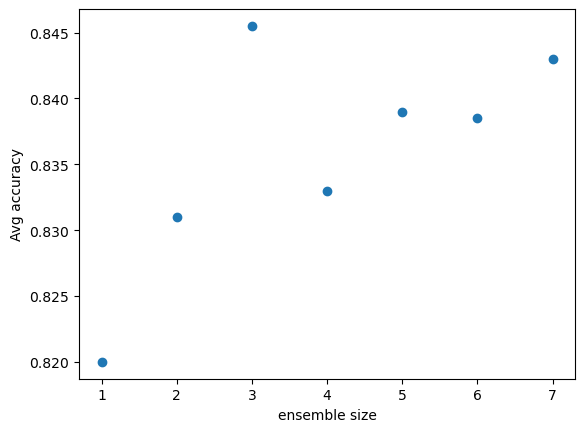

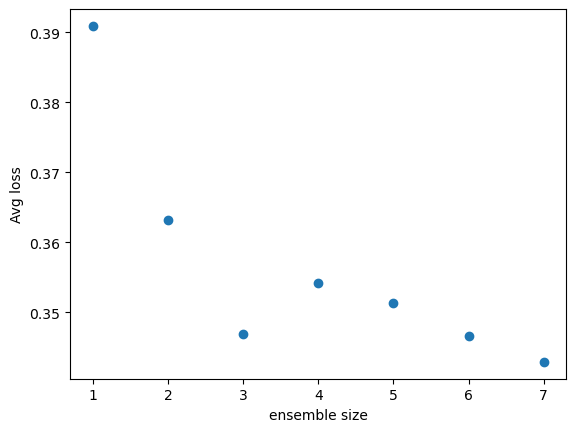

In [14]:
import matplotlib.pyplot as plt

plt.scatter(range(1, 8), accuracies)
plt.xlabel("ensemble size")
plt.ylabel("Avg accuracy")
plt.show()
plt.scatter(range(1, 8), losses)
plt.xlabel("ensemble size")
plt.ylabel("Avg loss")
plt.show()